In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon,box
import numpy as np
import pickle
import shapely

In [41]:
name = 'shapefiles/'
france_gdf = gpd.read_file(name+'gadm41_FRA_shp/gadm41_FRA_0.shp')
poland_gdf = gpd.read_file(name+'gadm41_POL_shp/gadm41_POL_0.shp')
hungary_gdf = gpd.read_file(name+'gadm41_HUN_shp/gadm41_HUN_0.shp')
slovakia_gdf = gpd.read_file(name+'gadm41_SVK_shp/gadm41_SVK_0.shp')
netherlands_gdf = gpd.read_file(name+'gadm41_NLD_shp/gadm41_NLD_0.shp')
czech_gdf = gpd.read_file(name+'gadm41_CZE_shp/gadm41_CZE_0.shp')
belgium_gdf = gpd.read_file(name+'gadm41_BEL_shp/gadm41_BEL_0.shp')
austria_gdf = gpd.read_file(name+'gadm41_AUT_shp/gadm41_AUT_0.shp')
croatia_gdf = gpd.read_file(name+'gadm41_HRV_shp/gadm41_HRV_0.shp')
bosnia_gdf = gpd.read_file(name+'gadm41_BIH_shp/gadm41_BIH_0.shp')
swis_gdf = gpd.read_file(name+'gadm41_CHE_shp/gadm41_CHE_0.shp')
italy_gdf = gpd.read_file(name+'gadm41_ITA_shp/gadm41_ITA_0.shp')
slovenia_gdf = gpd.read_file(name+'gadm41_SVN_shp/gadm41_SVN_0.shp')
spain_gdf = gpd.read_file(name+'gadm41_ESP_shp/gadm41_ESP_0.shp')
portugal_gdf = gpd.read_file(name+'gadm41_PRT_shp/gadm41_PRT_0.shp')


europe = france_gdf.append([poland_gdf,hungary_gdf,slovakia_gdf,netherlands_gdf,czech_gdf,belgium_gdf,austria_gdf,croatia_gdf,bosnia_gdf,swis_gdf,italy_gdf,slovenia_gdf,spain_gdf,portugal_gdf])
europe

/var/folders/m1/mwsfhs9s3lj_v878yxkbk1s40000gn/T/ipykernel_91557/1312274624.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  europe = france_gdf.append([poland_gdf,hungary_gdf,slovakia_gdf,netherlands_gdf,czech_gdf,belgium_gdf,austria_gdf,croatia_gdf,bosnia_gdf,swis_gdf,italy_gdf,slovenia_gdf,spain_gdf,portugal_gdf])


,GID_0,COUNTRY,geometry
0,FRA,France,"MULTIPOLYGON (((5.76875 43.07930, 5.76875 43.0..."
0,POL,Poland,"MULTIPOLYGON (((19.07021 49.41285, 19.07019 49..."
0,HUN,Hungary,"POLYGON ((18.27934 45.76139, 18.27127 45.76205..."
0,SVK,Slovakia,"POLYGON ((17.64901 47.79583, 17.63824 47.80233..."
0,NLD,Netherlands,"MULTIPOLYGON (((6.00713 50.75663, 6.00707 50.7..."
0,CZE,Czechia,"POLYGON ((14.71575 48.64993, 14.71586 48.64993..."
0,BEL,Belgium,"MULTIPOLYGON (((5.46629 49.49893, 5.46450 49.5..."
0,AUT,Austria,"MULTIPOLYGON (((14.28321 46.44377, 14.28309 46..."
0,HRV,Croatia,"MULTIPOLYGON (((16.80109 42.74768, 16.80125 42..."
0,BIH,Bosnia and Herzegovina,"POLYGON ((18.31409 42.62292, 18.30851 42.62146..."


<AxesSubplot:>

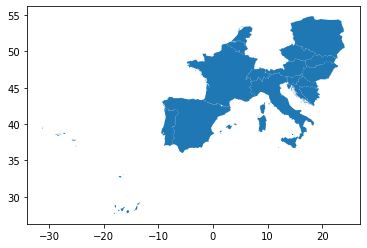

In [42]:
europe.plot()
plt.savefig('selected_map')


/var/folders/m1/mwsfhs9s3lj_v878yxkbk1s40000gn/T/ipykernel_91557/1946236584.py:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary=gpd.GeoSeries(cascaded_union(europe['geometry']))


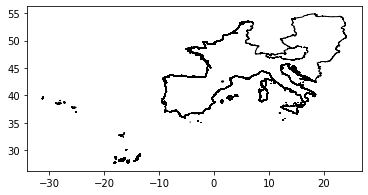

In [4]:
from shapely.ops import cascaded_union

boundary=gpd.GeoSeries(cascaded_union(europe['geometry']))
boundary.plot(color="none")
pickle.dump(boundary,open("map_boundaries.pkl","wb"))

In [5]:
def partition(polygon, dim, mergeFactor=0.1):
    bounds = polygon.bounds
    xmin = int(bounds['minx'] // dim)
    xmax = int(bounds['maxx'] // dim)
    ymin = int(bounds['miny'] // dim)
    ymax = int(bounds['maxy'] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)[0]
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result



In [6]:
PolyGrid = partition(boundary, 2, mergeFactor=0.25)

88

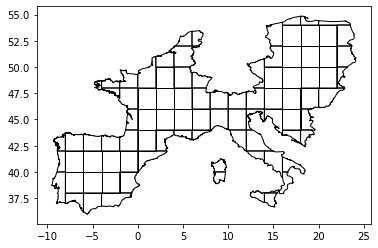

In [37]:
for i in PolyGrid.values():
    plt.plot(i[:,1],i[:,0],color='black',linewidth=1)
plt.savefig('selected_map_grid')
len(PolyGrid)
# pickle.dump(PolyGrid,open("PolyGrid.pkl","wb"))

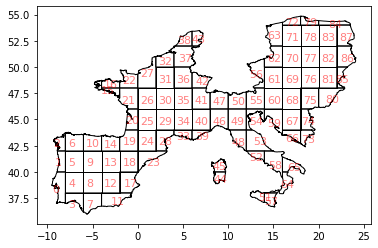

In [38]:
from shapely.geometry import Point, Polygon
import pylab as pl

for idx,i in enumerate(PolyGrid.values()):
    square = Polygon(i)
    midpoint_x = np.mean([square.bounds[1],square.bounds[3]])
    midpoint_y = np.mean([square.bounds[0],square.bounds[2]])
    plt.plot(i[:,1],i[:,0],color='black',linewidth=1)
    pl.text(midpoint_x-0.7,midpoint_y-0.4,str(idx),fontsize=11,color ='red',alpha=0.5)

plt.savefig('sslected_map_numbered')